# Assignment

In [29]:
# Imports 
import numpy as np
import matplotlib.pyplot as plt
from degree_freedom_queen import *
from degree_freedom_king1 import *
from degree_freedom_king2 import *
from generate_game import *
from Chess_env import *
import pandas as pd

size_board = 4

## The Environment

You can find the environment in the file Chess_env, which contains the class Chess_env. To define an object, you need to provide the board size considered as input. In our example, size_board=4. 
Chess_env is composed by the following methods:

1. Initialise_game. The method initialises an episode by placing the three pieces considered (Agent's king and queen, enemy's king) in the chess board. The outputs of the method are described below in order.

     S $\;$ A matrix representing the board locations filled with 4 numbers: 0, no piece in that position; 1, location of the 
     agent's king; 2 location of the queen; 3 location of the enemy king.
     
     X $\;$ The features, that is the input to the neural network. See the assignment for more information regarding the            definition of the features adopted. To personalise this, go into the Features method of the class Chess_env() and change        accordingly.
     
     allowed_a $\;$ The allowed actions that the agent can make. The agent is moving a king, with a total number of 8                possible actions, and a queen, with a total number of $(board_{size}-1)\times 8$ actions. The total number of possible actions correspond      to the sum of the two, but not all actions are allowed in a given position (movements to locations outside the borders or      against chess rules). Thus, the variable allowed_a is a vector that is one (zero) for an action that the agent can (can't)      make. Be careful, apply the policy considered on the actions that are allowed only.
     

2. OneStep. The method performs a one step update of the system. Given as input the action selected by the agent, it updates the chess board by performing that action and the response of the enemy king (which is a random allowed action in the settings considered). The first three outputs are the same as for the Initialise_game method, but the variables are computed for the position reached after the update of the system. The fourth and fifth outputs are:

     R $\;$ The reward. To change this, look at the OneStep method of the class where the rewards are set.
     
     Done $\;$ A variable that is 1 if the episode has ended (checkmate or draw).
     
     
3. Features. Given the chessboard position, the method computes the features.

This information and a quick analysis of the class should be all you need to get going. The other functions that the class exploits are uncommented and constitute an example on how not to write a python code. You can take a look at them if you want, but it is not necessary.






In [30]:
## INITIALISE THE ENVIRONMENT

env = Chess_Env(size_board)

In [31]:
## PRINT 5 STEPS OF AN EPISODE CONSIDERING A RANDOM AGENT

S, X, allowed_a = env.Initialise_game()                       # INTIALISE GAME

print(S)                                                  # PRINT CHESS BOARD (SEE THE DESCRIPTION ABOVE)

print('check? ', env.check)                                # PRINT VARIABLE THAT TELLS IF ENEMY KING IS IN CHECK (1) OR NOT (0)
print('dofk2 ', np.sum(env.dfk2_constrain).astype(int))    # PRINT THE NUMBER OF LOCATIONS THAT THE ENEMY KING CAN MOVE TO


for i in range(5):
    
    a, _ = np.where(allowed_a == 1)                  # FIND WHAT THE ALLOWED ACTIONS ARE
    a_agent = np.random.permutation(a)[0]         # MAKE A RANDOM ACTION

    S, X, allowed_a, R, Done = env.OneStep(a_agent)   # UPDATE THE ENVIRONMENT
    
    
    ## PRINT CHESS BOARD AND VARIABLES
    print('')
    print(S)
    print(R, '', Done)
    print('check? ', env.check)
    print('dofk2 ', np.sum(env.dfk2_constrain).astype(int))
    
    
    # TERMINATE THE EPISODE IF Done=True (DRAW OR CHECKMATE)
    if Done:
        break
        


[[0 0 0 0]
 [0 0 0 3]
 [0 2 0 0]
 [0 0 0 1]]
check?  0
dofk2  1

[[0 0 3 0]
 [0 0 0 0]
 [0 0 0 2]
 [0 0 0 1]]
0  0
check?  0
dofk2  1

[[0 0 0 0]
 [0 0 0 3]
 [0 2 0 0]
 [0 0 0 1]]
0  0
check?  0
dofk2  1

[[0 0 0 3]
 [2 0 0 0]
 [0 0 0 0]
 [0 0 0 1]]
0  0
check?  0
dofk2  1

[[0 0 3 0]
 [0 0 0 0]
 [0 2 0 0]
 [0 0 0 1]]
0  0
check?  0
dofk2  1

[[0 0 0 3]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 2 1]]
0  0
check?  0
dofk2  1


In [32]:
# PERFORM N_episodes=1000 EPISODES MAKING RANDOM ACTIONS AND COMPUTE THE AVERAGE REWARD AND NUMBER OF MOVES 

S, X, allowed_a = env.Initialise_game()
N_episodes = 10

# VARIABLES WHERE TO SAVE THE FINAL REWARD IN AN EPISODE AND THE NUMBER OF MOVES 
R_save_random = np.zeros([N_episodes, 1])
N_moves_save_random = np.zeros([N_episodes, 1])

for n in range(N_episodes):
    
    S, X, allowed_a = env.Initialise_game()     # INITIALISE GAME
    Done = 0                                  # SET Done=0 AT THE BEGINNING
    i = 1                                     # COUNTER FOR THE NUMBER OF ACTIONS (MOVES) IN AN EPISODE
    
    # UNTIL THE EPISODE IS NOT OVER...(Done=0)
    while Done == 0:
        
        # SAME AS THE CELL BEFORE, BUT SAVING THE RESULTS WHEN THE EPISODE TERMINATES 
        
        a, _ = np.where(allowed_a == 1)
        a_agent = np.random.permutation(a)[0]

        S, X, allowed_a, R, Done = env.OneStep(a_agent)
                
        if Done:
            
            R_save_random[n] = np.copy(R)
            N_moves_save_random[n] = np.copy(i)

            break

        i = i + 1                               # UPDATE THE COUNTER



# AS YOU SEE, THE PERFORMANCE OF A RANDOM AGENT ARE NOT GREAT, SINCE THE MAJORITY OF THE POSITIONS END WITH A DRAW 
# (THE ENEMY KING IS NOT IN CHECK AND CAN'T MOVE)

print('Random_Agent, Average reward:', np.mean(R_save_random),'Number of steps: ', np.mean(N_moves_save_random))

Random_Agent, Average reward: 0.1 Number of steps:  10.2


In [33]:
# Epsilon-Greedy Policy
def EpsilonGreedy_Policy(Qvalues, epsilon, allowed):

    N_allowed = np.shape(allowed)[0]

    Qvalues_of_allowed = Qvalues[allowed]
    
    rand_value = np.random.uniform(0,1)

    rand_a = rand_value < epsilon

    if rand_a == True:

        temp = np.random.randint(0, N_allowed)
        a = allowed[temp]

    else:

        temp = np.argmax(Qvalues_of_allowed)
        a = allowed[temp]
            
    return a

In [39]:
# INITIALISE THE PARAMETERS OF YOUR NEURAL NETWORK AND...
# PLEASE CONSIDER TO USE A MASK OF ONE FOR THE ACTION MADE AND ZERO OTHERWISE IF YOU ARE NOT USING VANILLA GRADIENT DESCENT...
# WE SUGGEST A NETWORK WITH ONE HIDDEN LAYER WITH SIZE 200. 

S, X, allowed_a = env.Initialise_game()
N_a = np.shape(allowed_a)[0]   # TOTAL NUMBER OF POSSIBLE ACTIONS
N_in = np.shape(X)[0]    ## INPUT SIZE
N_h = 200                ## NUMBER OF HIDDEN NODES

# INITALISE YOUR NEURAL NETWORK...

repeat_multiple_times = 1 # THE NUMBER OF TIMES THE EXPERIMENT IS REPEATED (TO GET MORE ACCURATE RESULTS)

# Set to 1 for reproducibility
if repeat_multiple_times == 1:
    np.random.seed(93)

# HYPERPARAMETERS SUGGESTED (FOR A GRID SIZE OF 4)

epsilon_0 = 0.3     # STARTING VALUE OF EPSILON FOR THE EPSILON-GREEDY POLICY
betas = [0.00005]      # THE PARAMETER SETS HOW QUICKLY THE VALUE OF EPSILON IS DECAYING (SEE epsilon_f BELOW)
gammas = [0.85]       # THE DISCOUNT FACTOR
eta = 0.0035       # THE LEARNING RATE
lamb = 0
types = ["SARSA"]

beta = 0.00005
gamma = 0.85
eta = 0.0035

N_episodes = 50000 # THE NUMBER OF GAMES TO BE PLAYED 

# Arrays to save the results
all_N_moves = []
all_R_save = []
legends = []
temp_moves = []
temp_R = []

# Eligibility traces
eligibility_trace = True
if eligibility_trace:    
    lamb = 0.3
    eta = 0.01

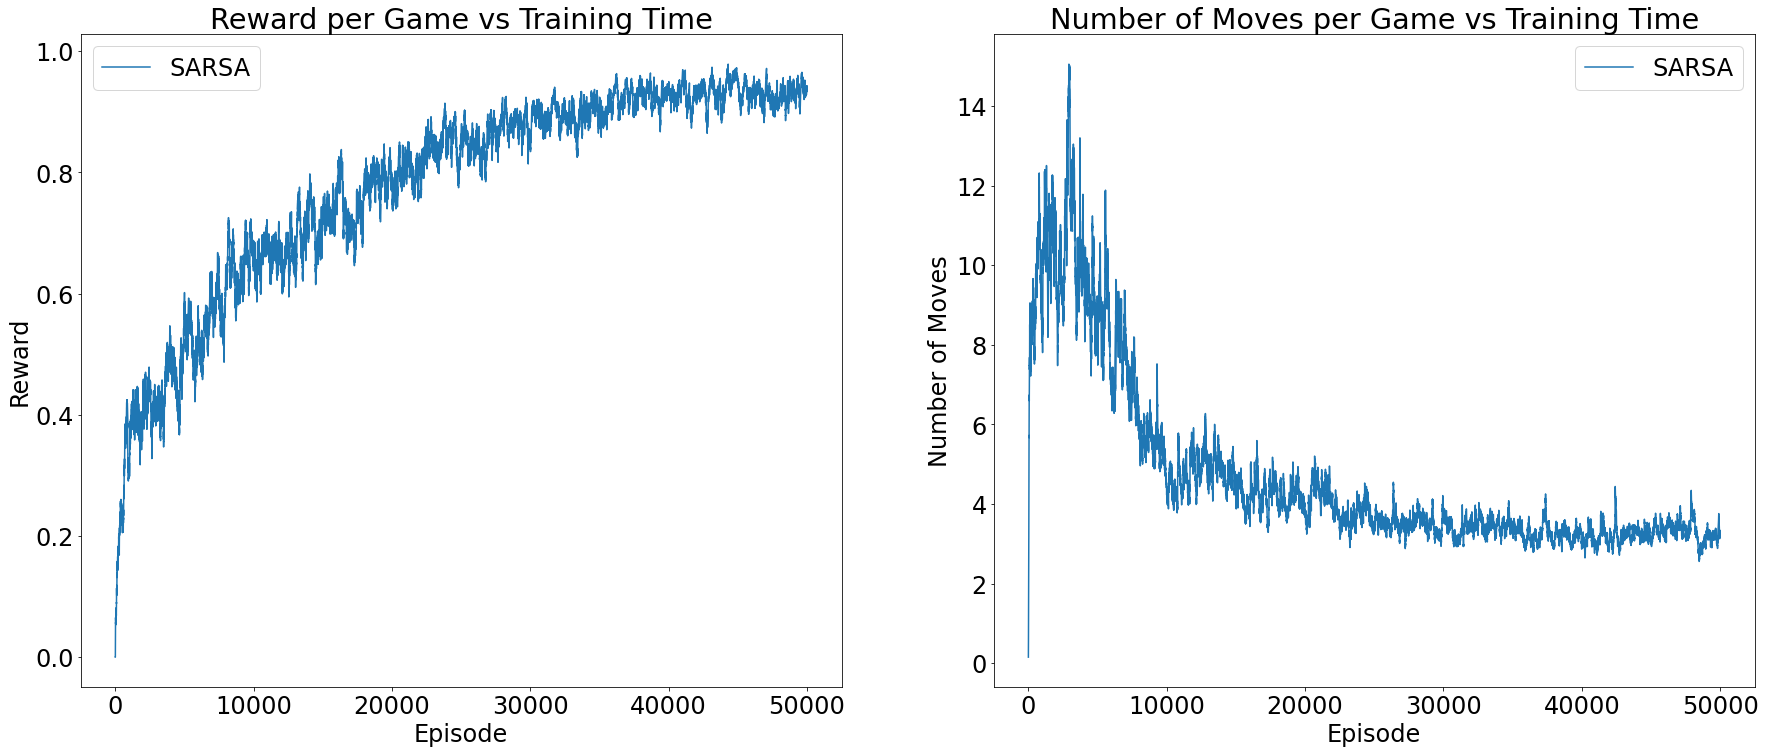

In [41]:
# SARSA implementation

R_save = np.zeros([N_episodes, 1])
N_moves_save = np.zeros([N_episodes, 1])

# Weights and biases
W1 = np.random.randn(N_h, N_in) * 0.001
b1 = np.zeros((N_h,))
W2 = np.random.randn(N_a, N_h) * 0.001
b2 = np.zeros((N_a,))

for n in range(N_episodes):
    epsilon_f = epsilon_0 / (1 + beta * n)   ## DECAYING EPSILON
    Done = 0                                   ## SET DONE TO ZERO (BEGINNING OF THE EPISODE)
    i = 1                                    ## COUNTER FOR NUMBER OF ACTIONS

    S, X, allowed_a = env.Initialise_game()      ## INITIALISE GAME

    # Initialise eligibility traces 
    if eligibility_trace:
        e = np.zeros(N_a,)

    h1 = np.matmul(W1, X) + b1
    # Apply the ReLU activation function
    x1 = np.maximum(0, h1)
    # Compute Qvalues
    Qvalues = np.matmul(W2, x1) + b2
    a, _ = np.where(allowed_a == 1)
    a_agent = EpsilonGreedy_Policy(Qvalues, epsilon_f, a)

    while not Done:  ## START THE EPISODE

        # Forward propagation
        h1 = np.matmul(W1, X) + b1
        # Apply the ReLU activation function
        x1 = np.maximum(0, h1)
        # Compute Qvalues
        Qvalues = np.matmul(W2, x1) + b2

        S_next, X_next, allowed_a_next, R, Done = env.OneStep(a_agent)

        # Update the eligibility trace for the action made
        if eligibility_trace:
            e[a_agent] = e[a_agent] + 1

        if Done:
                                
            # Backward propagation
            delta2 = R - Qvalues[a_agent]

            eta_delta2 = eta * delta2
            W2[a_agent] = W2[a_agent] + eta_delta2 * x1
            b2[a_agent] = b2[a_agent] + eta_delta2

            # update the weights of the hidden layer
            delta1 = np.dot(W2[a_agent], delta2) * (x1 > 0)

            W1 = W1 + eta * np.outer(delta1, X)
            b1 = b1 + eta * delta1

            # Calculate exponential moving average of the reward and number of moves
            # based on the code given in the slides
            if n == 0:
                R_save[n] = np.copy(R) * eta
                N_moves_save[n] = np.copy(i) * eta
            else:
                R_save[n] = (1 - eta) * R_save[n - 1] + eta * np.copy(R)
                N_moves_save[n] = (1 - eta) * N_moves_save[n - 1] + eta * np.copy(i)

            if eligibility_trace:
                W2 = W2 + eta_delta2 * np.outer(e, x1)
                b2 = b2 + eta_delta2 * e

            break
        
        else:

            h1 = np.matmul(W1, X_next) + b1
                                
            # Apply the ReLU activation function
            x1 = np.maximum(0, h1)

            # Compute Qvalues
            Qvalues1 = np.matmul(W2, x1) + b2
                                
            a1, _ = np.where(allowed_a_next == 1)

            a1_agent = EpsilonGreedy_Policy(Qvalues1, epsilon_f, a1)

            # Backward propagation
            delta2 = R + gamma * Qvalues1[a1_agent] - Qvalues[a_agent]

            eta_delta2 = eta * delta2
                                
            W2[a_agent] = W2[a_agent] + eta_delta2 * x1
            b2[a_agent] = b2[a_agent] + eta_delta2

            delta1 = np.dot(W2[a_agent], delta2) * (x1 > 0)

            W1 = W1 + eta * np.outer(delta1, X)
            b1 = b1 + eta * delta1

            if eligibility_trace:
                W2 = W2 + eta_delta2 * np.outer(e, x1)
                b2 = b2 + eta_delta2 * e
                e = gamma * lamb * e

        # NEXT STATE AND CO. BECOME ACTUAL STATE...
        S = np.copy(S_next)
        X = np.copy(X_next)
        allowed_a = np.copy(allowed_a_next)

        a_agent = np.copy(a1_agent)
                            
        i += 1  # UPDATE COUNTER FOR NUMBER OF ACTIONS

# Save to temp arrays   
temp_moves.append(N_moves_save)
temp_R.append(R_save)

plt.rcParams.update({'font.size': 24})
fig, axs = plt.subplots(1, 2, figsize=(30, 12))

# Plot Reward per Game vs Training Time
axs[0].plot(np.arange(N_episodes), R_save.flatten(), label="SARSA")
axs[0].set_xlabel('Episode')
axs[0].set_ylabel('Reward')
axs[0].set_title("Reward per Game vs Training Time")
axs[0].legend()

# Plot Number of Moves per Game vs Training Time
axs[1].plot(np.arange(N_episodes), N_moves_save.flatten(), label="SARSA")
axs[1].set_xlabel('Episode')
axs[1].set_ylabel('Number of Moves')
axs[1].set_title("Number of Moves per Game vs Training Time")
axs[1].legend()

# Save the combined figure
plt.savefig('SARSA_plots.jpg')


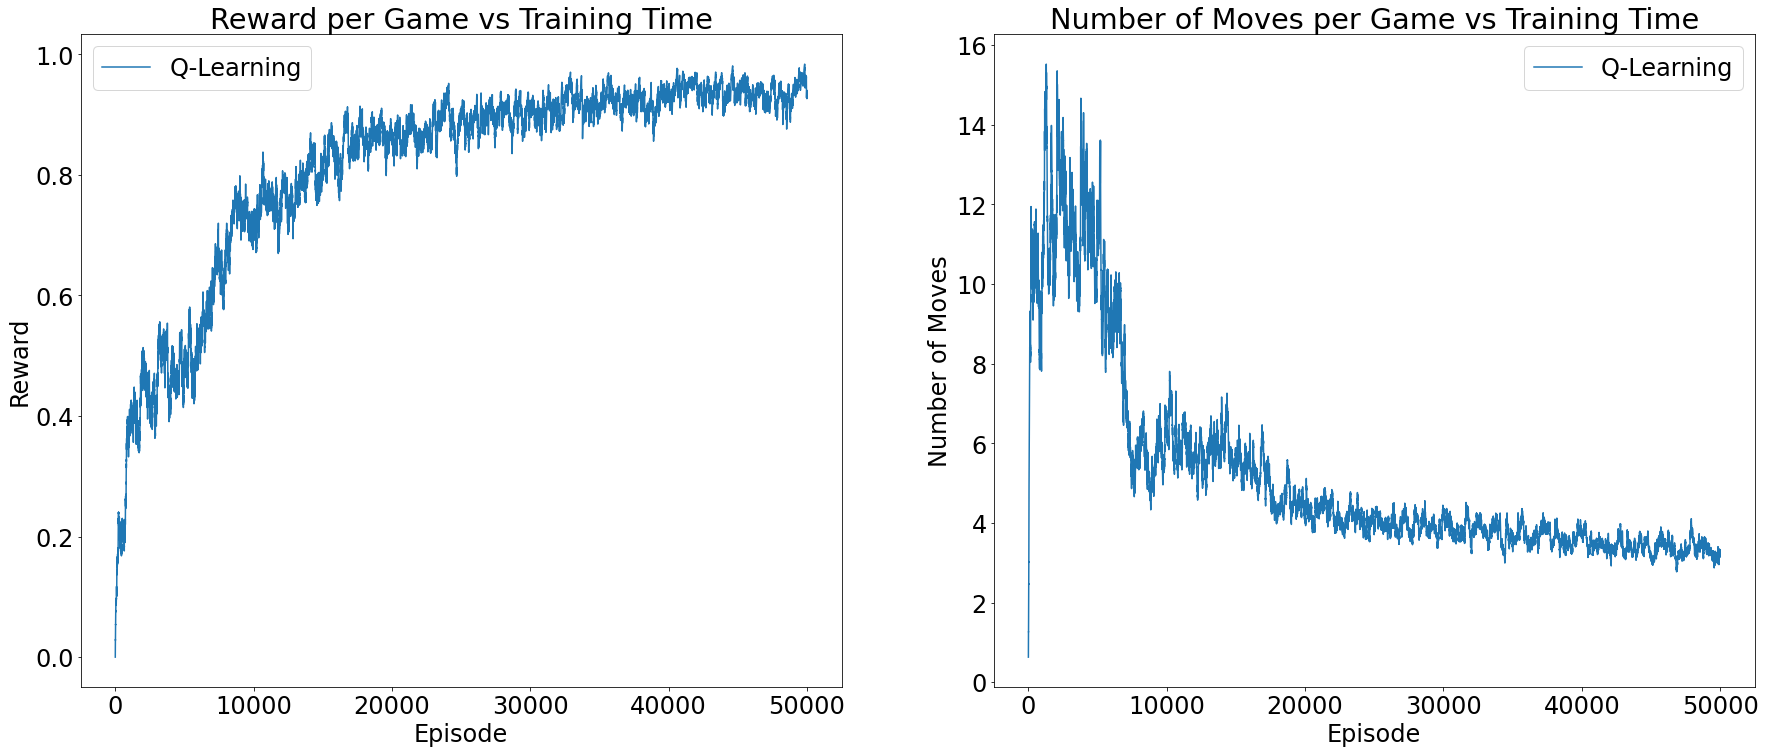

In [42]:
# Q-Learning implementation

# SAVING VARIABLES
R_save = np.zeros([N_episodes, 1])
N_moves_save = np.zeros([N_episodes, 1])

# Weights and biases
W1 = np.random.randn(N_h, N_in) * 0.001
b1 = np.zeros((N_h,))
W2 = np.random.randn(N_a, N_h) * 0.001
b2 = np.zeros((N_a,))

for n in range(N_episodes):

    epsilon_f = epsilon_0 / (1 + beta * n)   ## DECAYING EPSILON
    Done = 0                                   ## SET DONE TO ZERO (BEGINNING OF THE EPISODE)
    i = 1                                    ## COUNTER FOR NUMBER OF ACTIONS

    S, X, allowed_a = env.Initialise_game()      ## INITIALISE GAME
                        
    # Initialise eligibility traces 
    if eligibility_trace:
        e = np.zeros(N_a,)

    while not Done:

        # Forward propagation
        h1 = np.matmul(W1, X) + b1
        # Apply the ReLU activation function
        x1 = np.maximum(0, h1)
        # Compute Qvalues
        Qvalues = np.matmul(W2, x1) + b2
                                        
        a, _ = np.where(allowed_a == 1)
        a_agent = EpsilonGreedy_Policy(Qvalues, epsilon_f, a)

        S_next, X_next, allowed_a_next, R, Done = env.OneStep(a_agent)

        # Update the eligibility trace for the action made
        if eligibility_trace:
            e[a_agent] = e[a_agent] + 1

        if Done:

            # Backward propagation
            delta2 = R - Qvalues[a_agent]

            eta_delta2 = eta * delta2
            W2[a_agent] = W2[a_agent] + eta_delta2 * x1
            b2[a_agent] = b2[a_agent] + eta_delta2

            # update the weights of the hidden layer
            delta1 = np.dot(W2[a_agent], delta2) * (x1 > 0)

            W1 = W1 + eta * np.outer(delta1, X)
            b1 = b1 + eta * delta1

            # Calculate exponential moving average of the reward and number of moves
            # based on the code given in the slides
            if n == 0:
                R_save[n] = np.copy(R) * eta
                N_moves_save[n] = np.copy(i) * eta
            else:
                R_save[n] = (1 - eta) * R_save[n - 1] + eta * np.copy(R)
                N_moves_save[n] = (1 - eta) * N_moves_save[n - 1] + eta * np.copy(i)

            if eligibility_trace:
                W2 = W2 + eta_delta2 * np.outer(e, x1)
                b2 = b2 + eta_delta2 * e

            break

        else:

            h1 = np.matmul(W1, X_next) + b1
                                
            # Apply the ReLU activation function
            x1 = np.maximum(0, h1)

            # Compute Qvalues
            Qvalues1 = np.matmul(W2, x1) + b2
                                
            a1, _ = np.where(allowed_a_next == 1)

            # Since EpsilonGreedy_Policy retrieves the index of the maximum of the Qvalues, we can use it for Q-learning
            a1_agent = EpsilonGreedy_Policy(Qvalues1, 0, a1)

            # Backward propagation
            delta2 = R + gamma * Qvalues1[a1_agent] - Qvalues[a_agent]

            eta_delta2 = eta * delta2
                                
            W2[a_agent] = W2[a_agent] + eta_delta2 * x1
            b2[a_agent] = b2[a_agent] + eta_delta2

            delta1 = np.dot(W2[a_agent], delta2) * (x1 > 0)

            W1 = W1 + eta * np.outer(delta1, X)
            b1 = b1 + eta * delta1

            if eligibility_trace:
                W2 = W2 + eta_delta2 * np.outer(e, x1)
                b2 = b2 + eta_delta2 * e
                e = gamma * lamb * e

        # NEXT STATE AND CO. BECOME ACTUAL STATE...
        S = np.copy(S_next)
        X = np.copy(X_next)
        allowed_a = np.copy(allowed_a_next)
                            
        i += 1  # UPDATE COUNTER FOR NUMBER OF ACTIONS


plt.rcParams.update({'font.size': 24})
fig, axs = plt.subplots(1, 2, figsize=(30, 12))

# Plot Reward per Game vs Training Time
axs[0].plot(np.arange(N_episodes), R_save.flatten(), label="Q-Learning")
axs[0].set_xlabel('Episode')
axs[0].set_ylabel('Reward')
axs[0].set_title("Reward per Game vs Training Time")
axs[0].legend()

# Plot Number of Moves per Game vs Training Time
axs[1].plot(np.arange(N_episodes), N_moves_save.flatten(), label="Q-Learning")
axs[1].set_xlabel('Episode')
axs[1].set_ylabel('Number of Moves')
axs[1].set_title("Number of Moves per Game vs Training Time")
axs[1].legend()

# Save the combined figure
plt.savefig('QLEARNING_plots.jpg')

In [35]:
# TRAINING LOOP BONE STRUCTURE...

# For each type of learning
for t in types:

    # For each gamma    
    for gamma in gammas:

        # For each beta
        for beta in betas:

            # Repeat the experiment multiple times to get average of runs       
            for rep in range(repeat_multiple_times):

                # SAVING VARIABLES
                R_save = np.zeros([N_episodes, 1])
                N_moves_save = np.zeros([N_episodes, 1])
                    
                
                learning_type = t # THE LEARNING TYPE (SARSA OR Q-learning)

                # Weights and biases
                W1 = np.random.randn(N_h, N_in) * 0.001
                b1 = np.zeros((N_h,))
                W2 = np.random.randn(N_a, N_h) * 0.001
                b2 = np.zeros((N_a,))

                for n in range(N_episodes):

                    epsilon_f = epsilon_0 / (1 + beta * n)   ## DECAYING EPSILON
                    Done = 0                                   ## SET DONE TO ZERO (BEGINNING OF THE EPISODE)
                    i = 1                                    ## COUNTER FOR NUMBER OF ACTIONS
                        
                    S, X, allowed_a = env.Initialise_game()      ## INITIALISE GAME
                        
                    # Initialise eligibility traces 
                    if eligibility_trace:
                        e = np.zeros(N_a,)

                    if learning_type == "SARSA":
                        h1 = np.matmul(W1, X) + b1
                        # Apply the ReLU activation function
                        x1 = np.maximum(0, h1)
                        # Compute Qvalues
                        Qvalues = np.matmul(W2, x1) + b2
                        a, _ = np.where(allowed_a == 1)
                        a_agent = EpsilonGreedy_Policy(Qvalues, epsilon_f, a)

                    while not Done:  ## START THE EPISODE

                        # Forward propagation
                        h1 = np.matmul(W1, X) + b1
                        # Apply the ReLU activation function
                        x1 = np.maximum(0, h1)
                        # Compute Qvalues
                        Qvalues = np.matmul(W2, x1) + b2
                            
                        if learning_type == "Q-learning":  
                            a, _ = np.where(allowed_a == 1)
                            a_agent = EpsilonGreedy_Policy(Qvalues, epsilon_f, a)

                        S_next, X_next, allowed_a_next, R, Done = env.OneStep(a_agent)

                        # Update the eligibility trace for the action made
                        if eligibility_trace:
                            e[a_agent] = e[a_agent] + 1

                        if Done:
                                
                            # Backward propagation
                            delta2 = R - Qvalues[a_agent]
                                
                            eta_delta2 = eta * delta2
                            W2[a_agent] = W2[a_agent] + eta_delta2 * x1
                            b2[a_agent] = b2[a_agent] + eta_delta2
                                
                            # update the weights of the hidden layer
                            delta1 = np.dot(W2[a_agent], delta2) * (x1 > 0)

                            W1 = W1 + eta * np.outer(delta1, X)
                            b1 = b1 + eta * delta1

                            # Calculate exponential moving average of the reward and number of moves
                            # based on the code given in the slides
                            if n == 0:
                                R_save[n] = np.copy(R) * eta
                                N_moves_save[n] = np.copy(i) * eta
                            else:
                                R_save[n] = (1 - eta) * R_save[n - 1] + eta * np.copy(R)
                                N_moves_save[n] = (1 - eta) * N_moves_save[n - 1] + eta * np.copy(i)

                            if eligibility_trace:
                                W2 = W2 + eta_delta2 * np.outer(e, x1)
                                b2 = b2 + eta_delta2 * e

                            break
                            
                        else:

                            h1 = np.matmul(W1, X_next) + b1
                                
                            # Apply the ReLU activation function
                            x1 = np.maximum(0, h1)

                            # Compute Qvalues
                            Qvalues1 = np.matmul(W2, x1) + b2
                                
                            a1, _ = np.where(allowed_a_next == 1)

                            if learning_type == "SARSA":
                                a1_agent = EpsilonGreedy_Policy(Qvalues1, epsilon_f, a1)
                            else:
                                # Since EpsilonGreedy_Policy retrieves the index of the maximum of the Qvalues, we can use it for Q-learning
                                # a1_agent = EpsilonGreedy_Policy(Qvalues1, 0, a)
                                a1_agent = EpsilonGreedy_Policy(Qvalues1, 0, a1)
                                    
                            # Backward propagation
                            delta2 = R + gamma * Qvalues1[a1_agent] - Qvalues[a_agent]

                            eta_delta2 = eta * delta2
                                
                            W2[a_agent] = W2[a_agent] + eta_delta2 * x1
                            b2[a_agent] = b2[a_agent] + eta_delta2

                            delta1 = np.dot(W2[a_agent], delta2) * (x1 > 0)

                            W1 = W1 + eta * np.outer(delta1, X)
                            b1 = b1 + eta * delta1

                            if eligibility_trace:
                                W2 = W2 + eta_delta2 * np.outer(e, x1)
                                b2 = b2 + eta_delta2 * e
                                e = gamma * lamb * e
                                
                        # NEXT STATE AND CO. BECOME ACTUAL STATE...
                        S = np.copy(S_next)
                        X = np.copy(X_next)
                        allowed_a = np.copy(allowed_a_next)

                        if learning_type == "SARSA":
                            a_agent = np.copy(a1_agent)
                            
                        i += 1  # UPDATE COUNTER FOR NUMBER OF ACTIONS

                # Save to temp arrays   
                temp_moves.append(N_moves_save)
                temp_R.append(R_save)

            # Add legend
            legends.append(learning_type + " γ =" + str(gamma) + " β = " + str(beta))
            
            # Compute mean over the runs
            temp_R = np.array(temp_R)
            temp_R = temp_R.reshape(-1, repeat_multiple_times, temp_R.shape[1]).mean(axis=1)
            all_R_save.append(temp_R)
            
            temp_moves = np.array(temp_moves)
            temp_moves = temp_moves.reshape(-1, repeat_multiple_times, temp_moves.shape[1]).mean(axis=1)
            all_N_moves.append(temp_moves)

            temp_moves = []
            temp_R = []

Learning type: SARSA Gamma: 0.85 beta 5e-05 Exponentioal moving average of rewards: 0.4892353092123547 Number of steps:  9.278319242863045


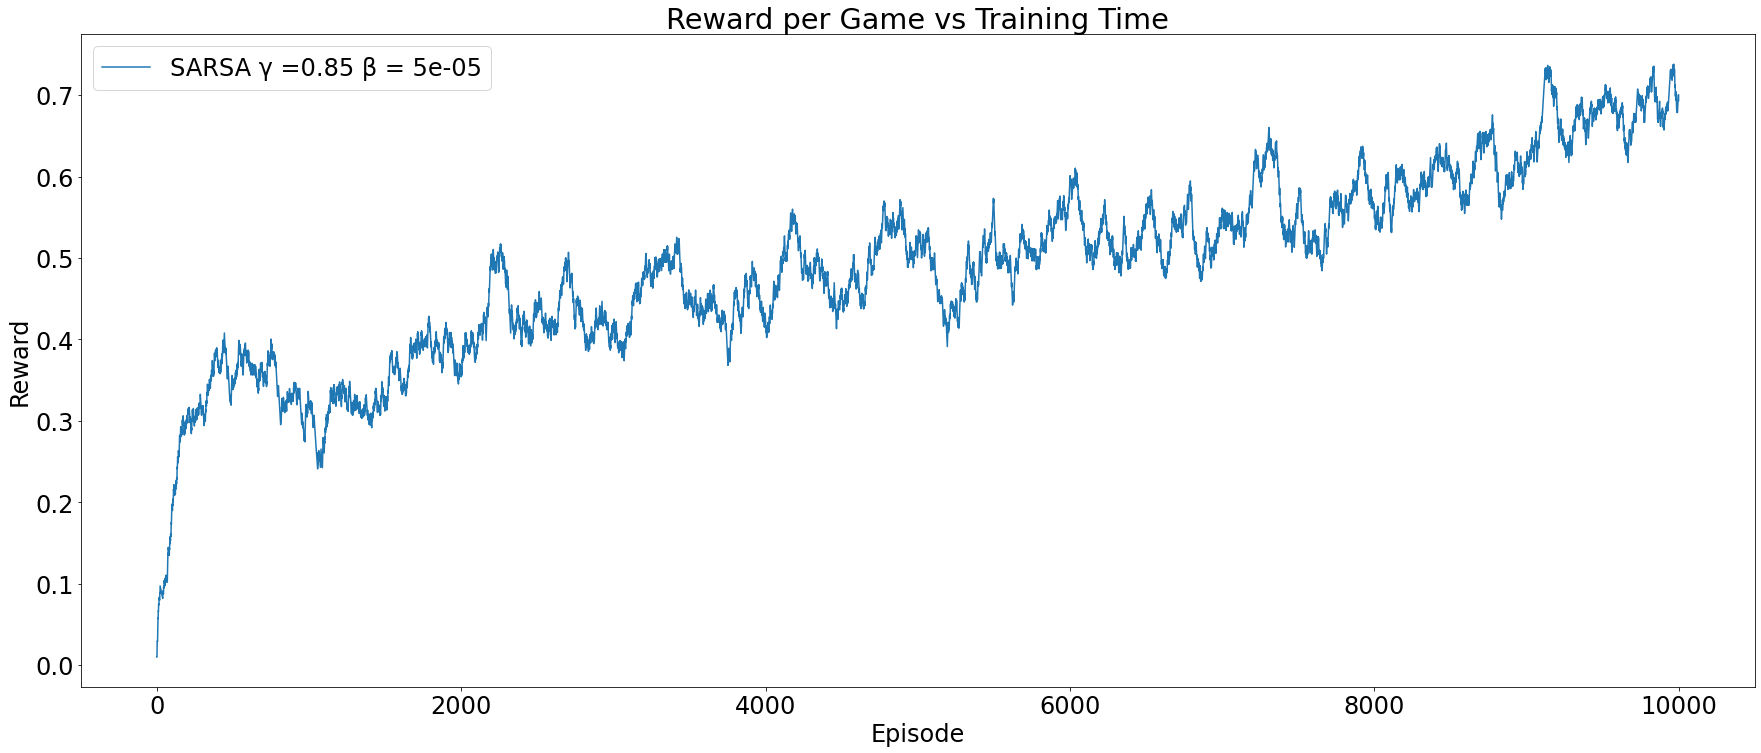

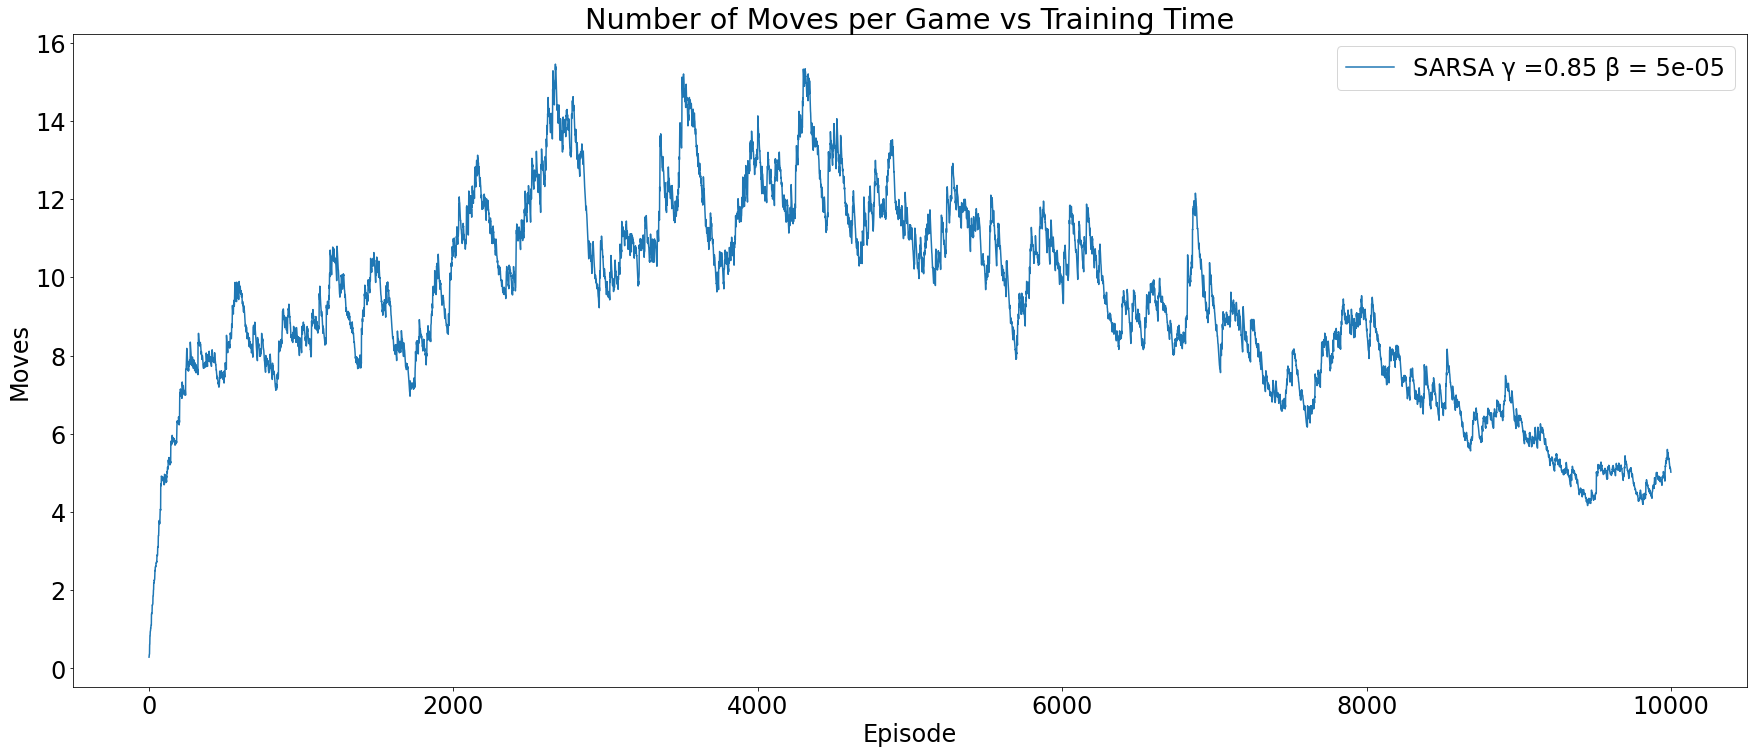

In [36]:
# Print the results
counter = 0
for t in types:
    for gamma in gammas:
        for beta in betas:
            print('Learning type:', t, 'Gamma:', gamma, 'beta', beta ,'Exponentioal moving average of rewards:',np.mean(all_R_save[counter]), 'Number of steps: ',np.mean(all_N_moves[counter]))
            counter += 1

# PLOT THE RESULTS

plt.rcParams.update({'font.size': 24})
plt.figure(figsize=(30, 12))
# for i, R_save in enumerate(all_R_save):
#     errors = 2 * np.std(R_save) / np.sqrt(N_episodes) 
#     plt.errorbar(np.arange(N_episodes), R_save.flatten(), errors, 0, elinewidth=2, capsize=4, alpha=0.8, errorevery=50)
plt.plot(np.arange(N_episodes), R_save.flatten(), label= legends[0])
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title("Reward per Game vs Training Time")
plt.legend(legends)
plt.savefig('EMA_Reward.png')

plt.rcParams.update({'font.size': 24})
plt.figure(figsize=(30, 12))
# for i, N_moves_save in enumerate(all_N_moves):
#     errors = 2 * np.std(N_moves_save) / np.sqrt(N_episodes) 
#     plt.errorbar(np.arange(N_episodes), N_moves_save.flatten(), errors, 0, elinewidth=2, capsize=4, alpha=0.8, errorevery=50)
plt.plot(np.arange(N_episodes), N_moves_save.flatten(), label = legends[0])
plt.xlabel('Episode')
plt.ylabel('Moves')
plt.title("Number of Moves per Game vs Training Time")
plt.legend(legends)
plt.savefig('EMA_Moves.png')